## Final Assignment Code - Athena Rodrigues

# Research Topic: Lyrical Sentiment Overtime (2000 - 2015)

In [97]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\athen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Cleaning

In [98]:
file_path = r"C:\Users\athen\Documents\GitHub\QTA_Spring2025\Final\all_songs_data.csv"
df = pd.read_csv(file_path)
print(df.columns)
#Drop Not Needed Columns
dropcolumns = ['Album', 'Album URL', 'Featured Artists', 'Rank', 'Media',
    'Release Date', 'Song URL', 'Writers']
df = df.drop(columns=dropcolumns)
print(df.columns)

#Keeping only songs from 2000 to 2015
df = df[(df['Year'] >= 2000) & (df['Year'] <= 2015)] #filter selected years
df = df.dropna(subset=['Lyrics']).reset_index(drop=True)
df['Year'] = df['Year'].astype(int)  #convert to integer
print(df['Year'].head)

Index(['Album', 'Album URL', 'Artist', 'Featured Artists', 'Lyrics', 'Media',
       'Rank', 'Release Date', 'Song Title', 'Song URL', 'Writers', 'Year'],
      dtype='object')
Index(['Artist', 'Lyrics', 'Song Title', 'Year'], dtype='object')
<bound method NDFrame.head of 0       2000
1       2000
2       2000
3       2000
4       2000
        ... 
1565    2015
1566    2015
1567    2015
1568    2015
1569    2015
Name: Year, Length: 1570, dtype: int32>


# Text Processing

In [99]:
custom_stopwords = set(stopwords.words('english')).union({
    'yeah', 'ooh', 'na', 'la', 'oh', 'ohoh', 'gotta', 'get', 'gonna',
    'come', 'baby', 'girl', 'boy', 'im', 'youre', 'ill', 'dont',
    'hey', 'uh', 'ah', 'woah', 'uhh', 'uhuh', 'nah', 'huh', 'let',
    'us', 'go', 'make', 'wanna', 'ive', 'aint', 'like', 'cause', 'ya',
    'said', 'got', 'one', 'time', 'never', 'know', 'back', 'see',
    'take', 'still', 'cant', 'heart', 'night', 'thing', 'want', 'way',
    'feat', 'mmm', 'woo', 'ooo', 'ohohoh', 'lala', 'oohoohoohooh', 'whoa',
    'nigga', 'bitch', 'shit', 'fuck', 'ass', 'damn', 'hoe', 'freak', 'hell', 'mf', 'suck'

})
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)               
    text = re.sub(r'[^a-z\s]', '', text)             
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords and len(word) > 2]
    return ' '.join(tokens)

df['clean_lyrics'] = df['Lyrics'].astype(str).apply(preprocess)
df = df[df['clean_lyrics'].str.split().str.len() > 10]


In [100]:
print(df.shape)
df.head()

(1569, 5)


,Artist,Lyrics,Song Title,Year,clean_lyrics
0,Faith Hill,[Intro] I can feel the magic floating in the a...,Breathe,2000,feel magic floating air get watch sunlight dan...
1,Santana feat. Rob Thomas,"[Verse 1] Man, it's a hot one Like seven inche...",Smooth,2000,man hot seven inch midday sun hear whisper wor...
2,Joe,"[Intro] Yeah, oh yeah Alright, oh, oh, oh [Ve...",I Wanna Know,2000,alright amazing knock foot every around weak n...
3,Vertical Horizon,[Verse 1] Somewhere there's speaking It's alre...,Everything You Want,2000,somewhere there speaking already coming rising...
4,Destiny's Child,"[Intro] Darkchild '99 [Chorus] Say my name, s...",Say My Name,2000,darkchild say name say name around say love ru...


# Topic Modelling

In [101]:
#Vectorization

vectorizer = CountVectorizer(
    max_df=0.95,        
    min_df=5,          
    stop_words='english'
)
X = vectorizer.fit_transform(df['clean_lyrics'])

In [102]:
#Fit LDA

lda = LatentDirichletAllocation(
    n_components=15,
    max_iter=10,
    learning_method='online',
    random_state=37
)
lda.fit(X)
topic_results = lda.transform(X)
df['dominant_topic'] = topic_results.argmax(axis=1)


In [103]:
#Print Topics
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx+1}: {', '.join(top_features)}")

print_topics(lda, vectorizer.get_feature_names_out())

Topic 1: fly, feel, place, holding, lover, ride, gimme, high, closer, drive
Topic 2: tonight, dance, let, ohh, floor, crazy, away, feel, arm, love
Topic 3: turn, rock, song, party, studio, light, music, play, body, stop
Topic 4: air, lonely, lean, que, shoulder, solo, gon, tired, ella, battlefield
Topic 5: right, think, know, long, head, home, going, shes, bad, really
Topic 6: lady, sexy, sugar, round, clean, style, pull, fresh, sprung, lip
Topic 7: good, little, shake, break, bout, girl, boom, fine, cmon, stop
Topic 8: tell, need, feel, wont, run, better, away, right, hard, say
Topic 9: diamond, world, god, people, blue, man, river, american, men, day
Topic 10: lose, away, hand, wake, man, moment, rain, caught, falling, sweet
Topic 11: money, gon, right, thats, hit, man, nigga, club, need, big
Topic 12: say, matter, bum, started, best, bay, doesnt, really, boo, believe
Topic 13: life, day, remember, beautiful, think, gone, live, sky, ready, pain
Topic 14: love, feel, kiss, deep, need,

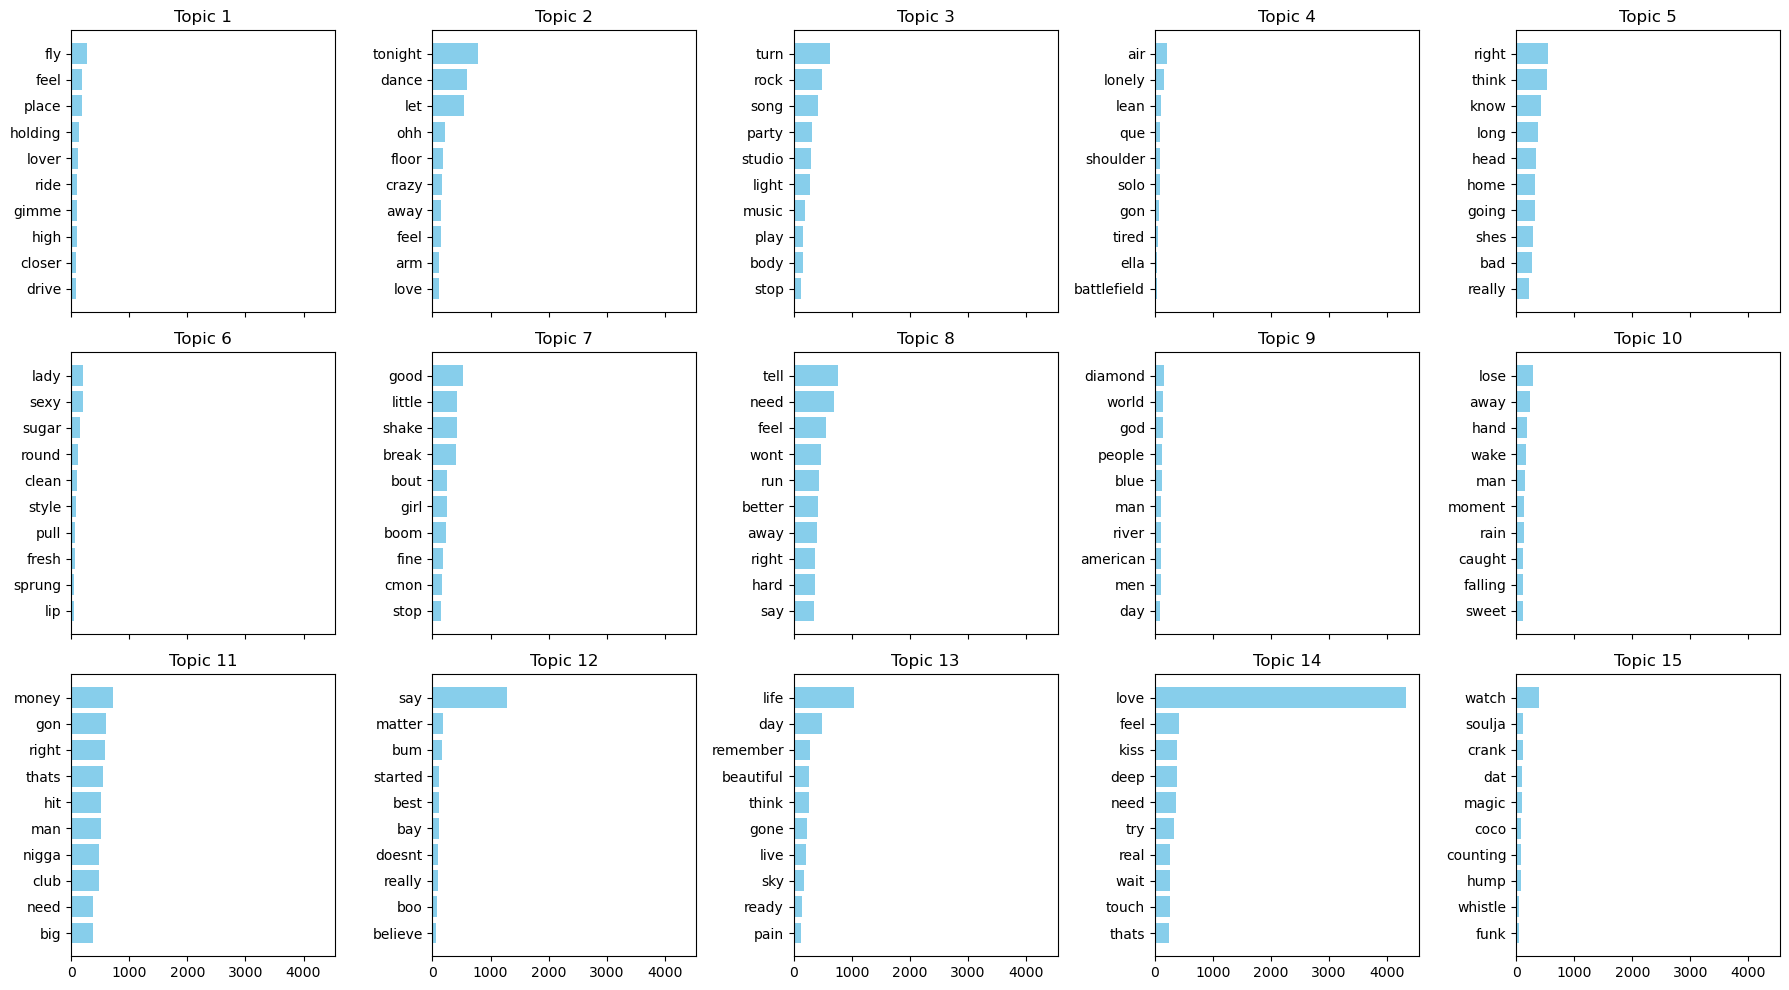

In [104]:

def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(3, 5, figsize=(18, 10), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue')
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

# Use with your fitted LDA model and CountVectorizer
plot_top_words(lda, vectorizer.get_feature_names_out())


Topic #1


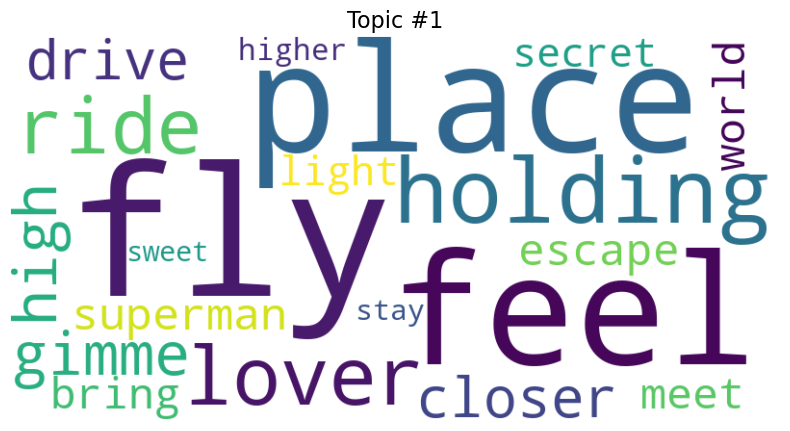

Topic #2


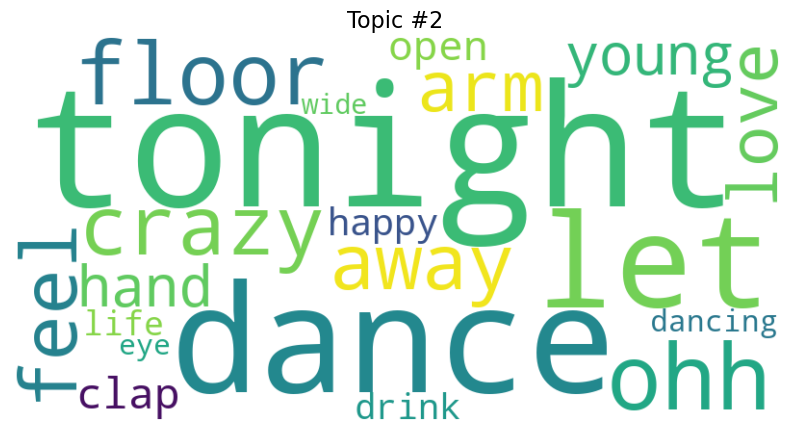

Topic #3


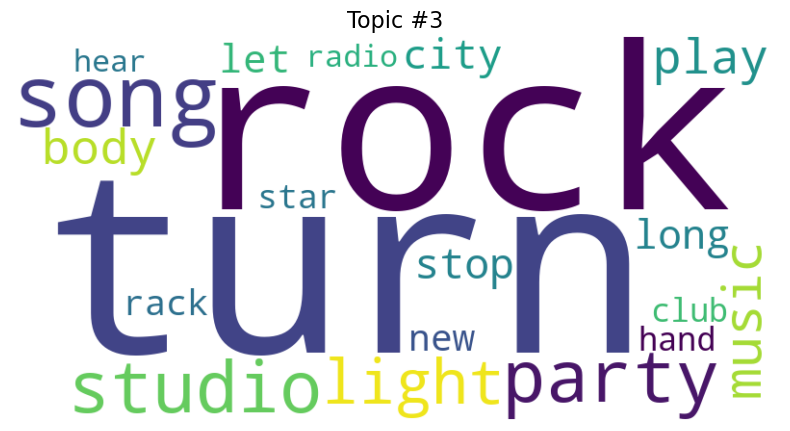

Topic #4


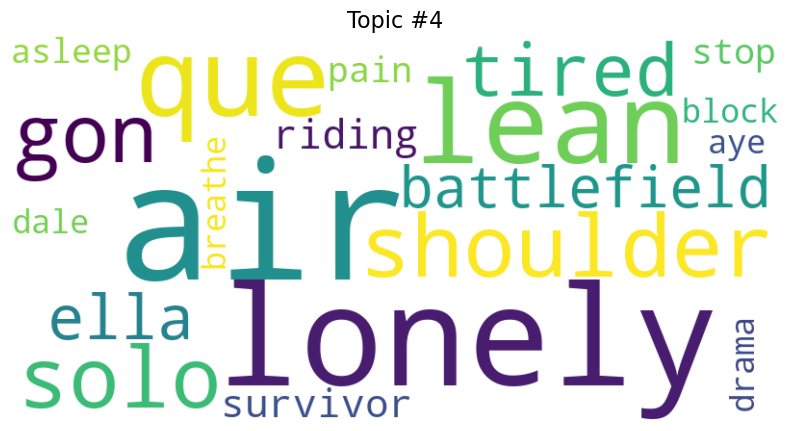

Topic #5


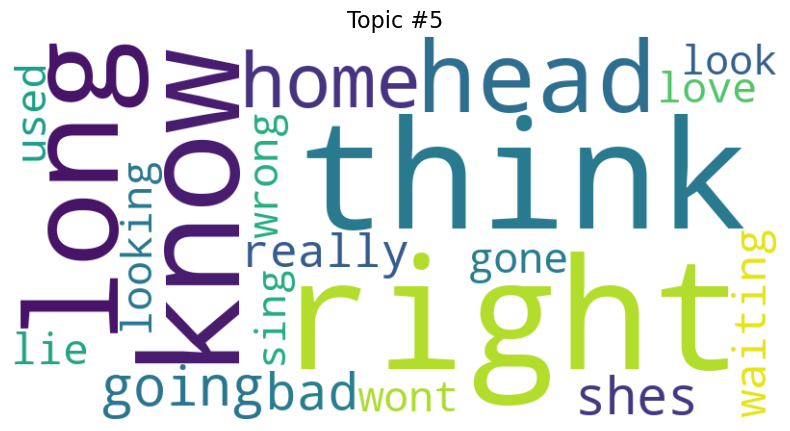

Topic #6


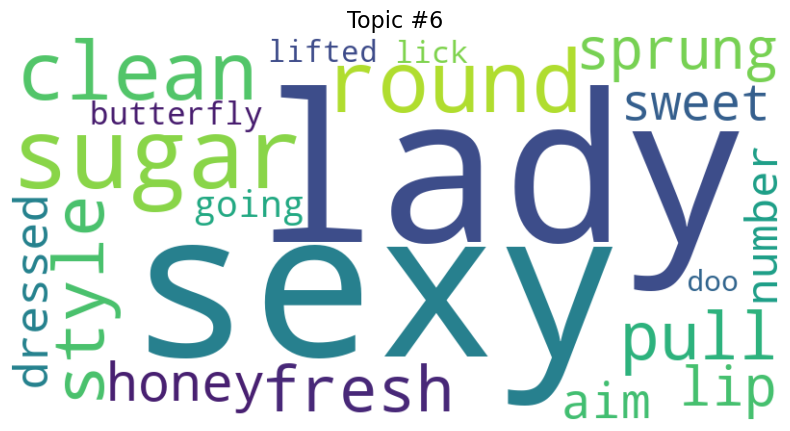

Topic #7


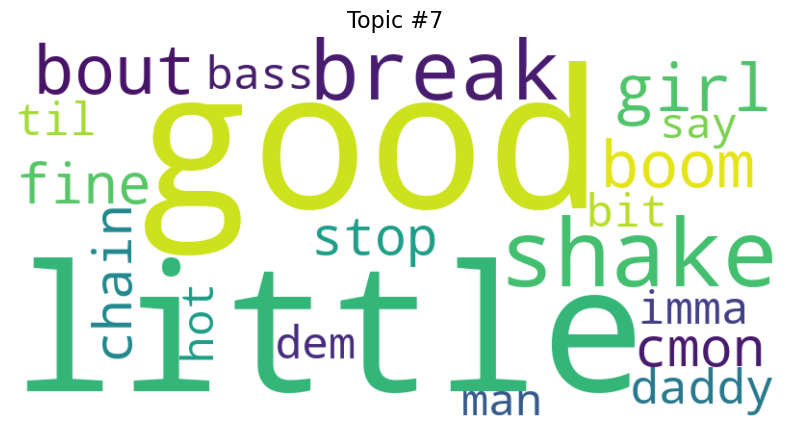

Topic #8


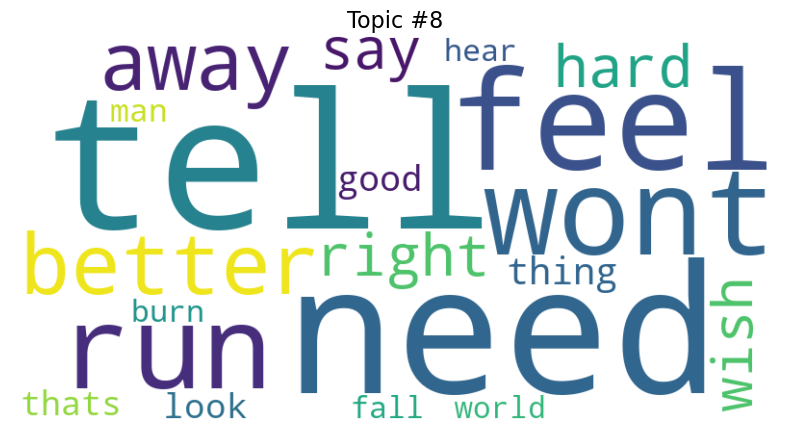

Topic #9


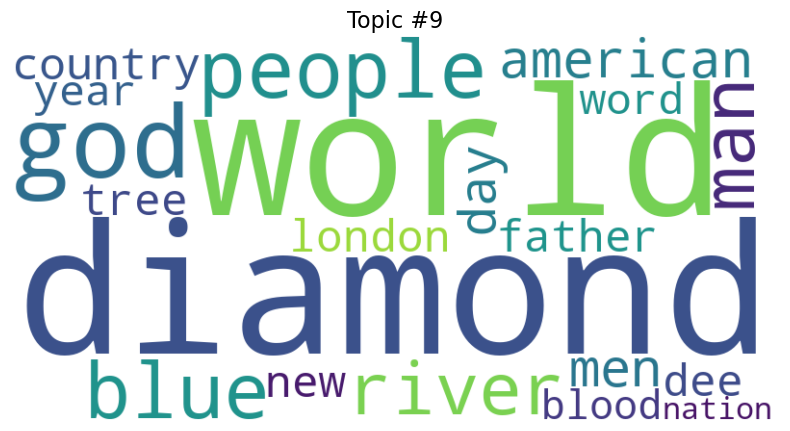

Topic #10


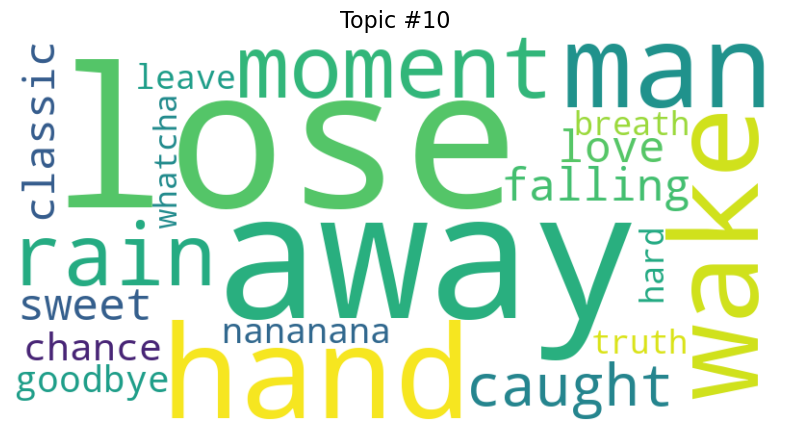

Topic #11


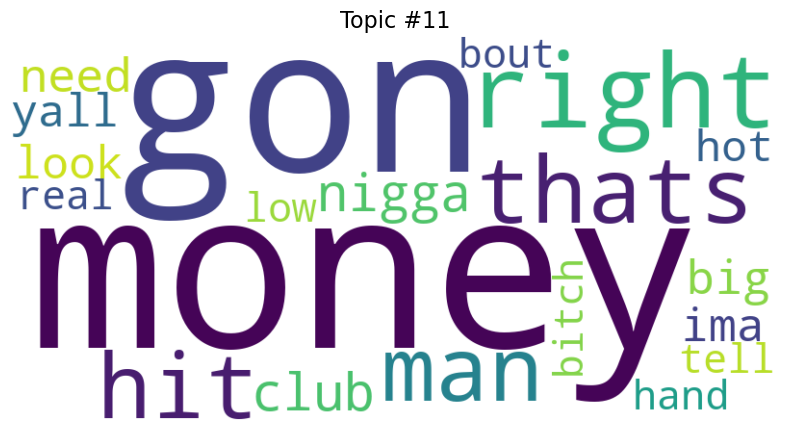

Topic #12


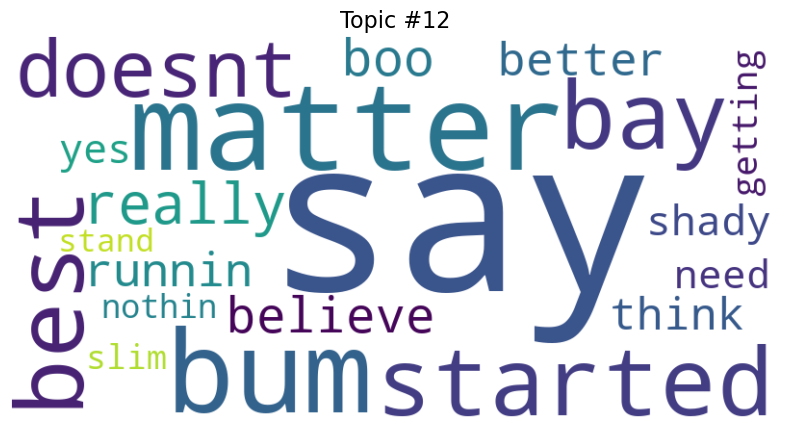

Topic #13


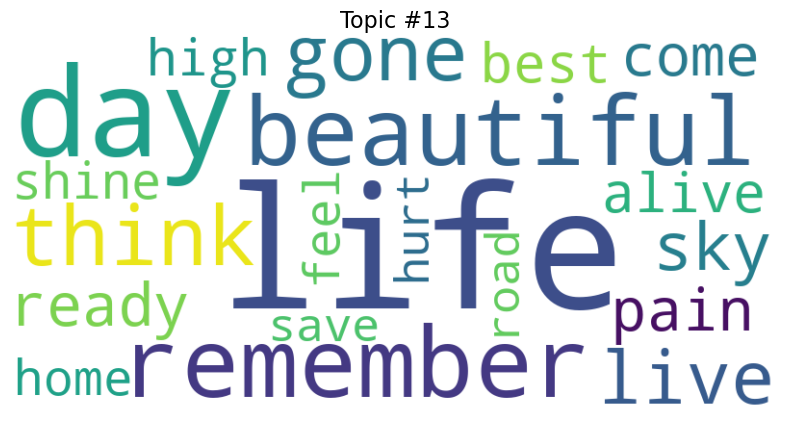

Topic #14


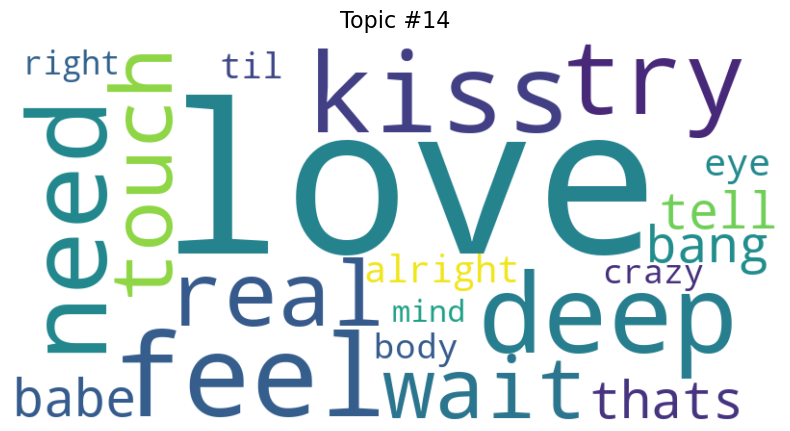

Topic #15


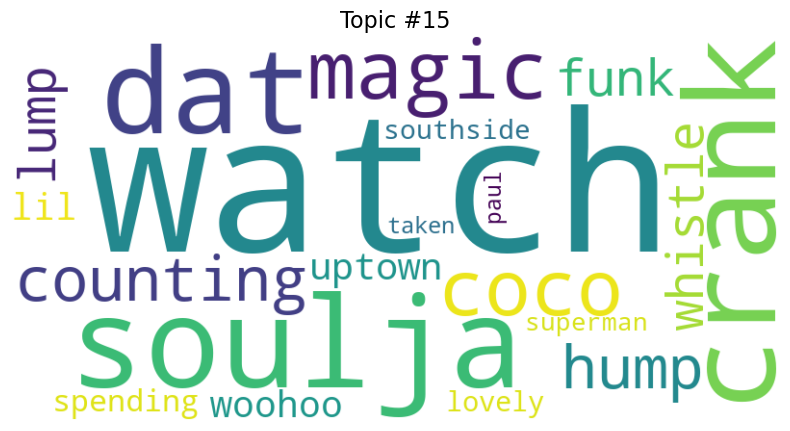

In [105]:

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic #{topic_idx + 1}')
    topic_words = {
        vectorizer.get_feature_names_out()[i]: topic[i]
        for i in topic.argsort()[:-20 - 1:-1]
    }
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic #{topic_idx + 1}', fontsize=16)
    plt.show()


# Sentiment Analysis

In [106]:
analyzer = SentimentIntensityAnalyzer()

# Create sentiment score columns
def get_sentiment_scores(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # ranges from -1 (neg) to +1 (pos)

df['sentiment_score'] = df['clean_lyrics'].apply(get_sentiment_scores)

# Optional: Categorize
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral')

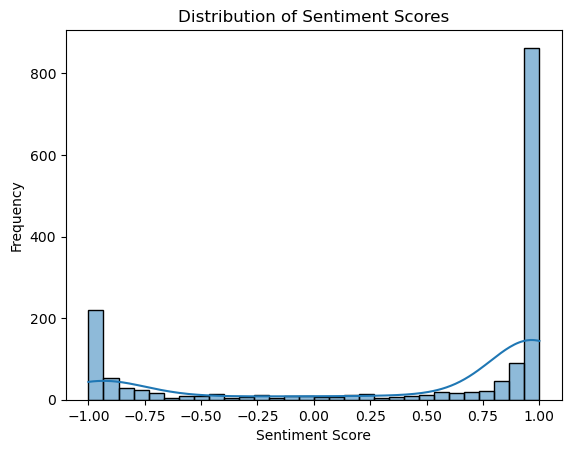

C:\Users\athen\AppData\Local\Temp\ipykernel_14256\2322047996.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='coolwarm')


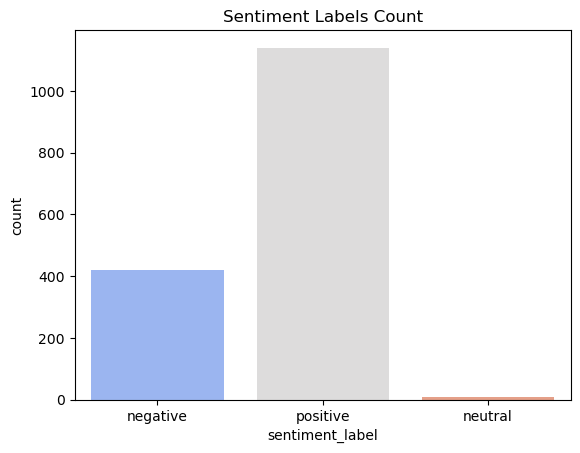

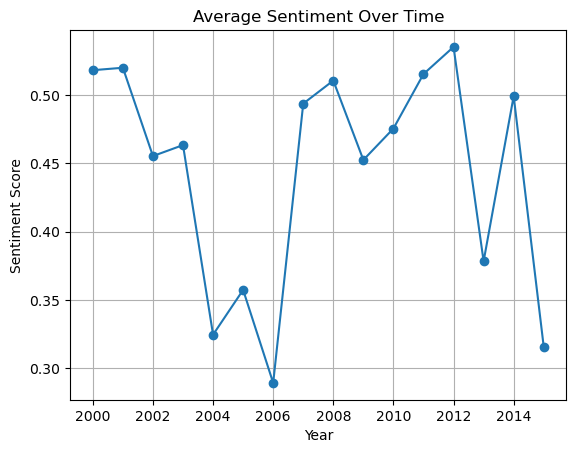

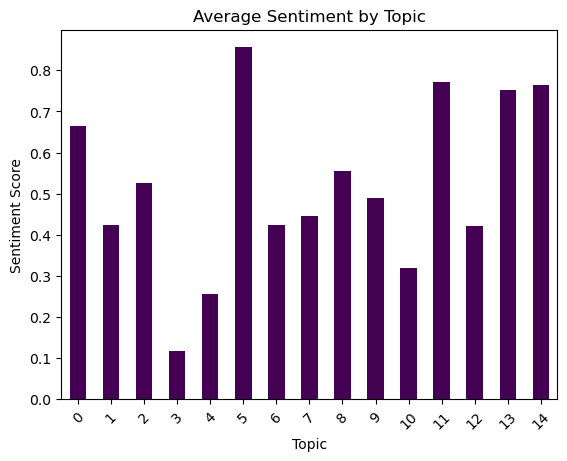

In [107]:
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

sns.countplot(data=df, x='sentiment_label', palette='coolwarm')
plt.title('Sentiment Labels Count')
plt.show()

df.groupby('Year')['sentiment_score'].mean().plot(kind='line', marker='o')
plt.title('Average Sentiment Over Time')
plt.ylabel('Sentiment Score')
plt.xlabel('Year')
plt.grid(True)
plt.show()

topic_sentiment = df.groupby('dominant_topic')['sentiment_score'].mean()
topic_sentiment.plot(kind='bar', colormap='viridis')
plt.title('Average Sentiment by Topic')
plt.ylabel('Sentiment Score')
plt.xlabel('Topic')
plt.xticks(rotation=45)
plt.show()



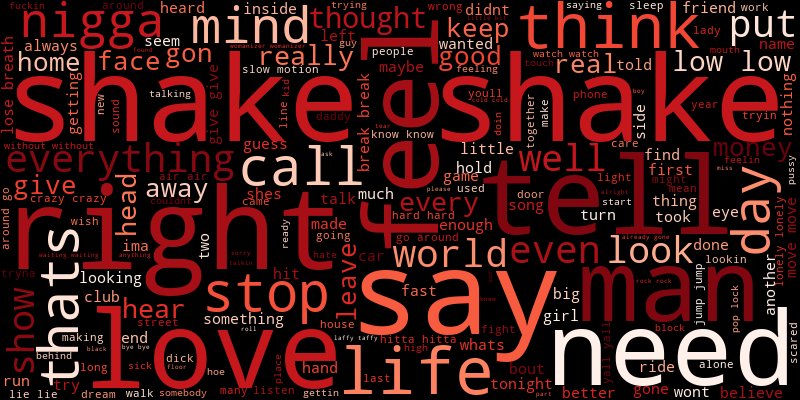

In [108]:

positive_text = ' '.join(df[df['sentiment_label'] == 'positive']['clean_lyrics'])
negative_text = ' '.join(df[df['sentiment_label'] == 'negative']['clean_lyrics'])

# Positive
WordCloud(width=800, height=400, background_color='white').generate(positive_text).to_image()

# Negative
WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text).to_image()
